# Advesarial Example using FGSM

텐서플로우 튜토리얼 ([LINK])(https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/adversarial_fgsm.ipynb) 에 있는거.

아래 fast gradient sign method 구현 부분만 잘 보아도 됨.

이미지에 대한 target class 로 gradient 구할 때, 이미지를 GradientTape.watch(image) 로 지켜보아야 gradient 를 구할 수 있다 (연구실 텐서플로우2 튜토리얼에서 모델 학습시킬 때, trainable_variables 를 자동으로 보는 것과 다름을 주의하자).

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0


In [3]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline

## matplotlib 그림 그리는 스타일을 어찌할거냐 정하기

In [4]:
mpl.rcParams['figure.figsize'] = (8,8)
mpl.rcParams['axes.grid'] = False

## Helper functions

In [5]:
def preprocess(image):
    '''
    args:
        image: 변환하고자 하는 이미지
    return:
        tf.float32 로 형변환
        픽셀값 정규화
        그림 크기 정규화
        axis = 0 에 차원 하나 추가해줌 (prediction 시키려면 4차원 데이터를 넣어주어야 함)
    '''
    
    image = tf.cast(image, tf.float32) # 이미지 형변환
    image = image/255 # 정규화
    image = tf.image.resize(image, (224, 224)) # 그림 크기 맞춰줌
    image = image[None, ...] # expand_dim 에 axis=0 한거랑 같음
    return image

def unresize(image, size):
    return tf.image.resize(image,size)

def get_imagenet_label(probs):
    '''
    args:
        이미지 prediction 한 결과 (1000개 클래스 각각에 대해 해당 클래스에 속할 확률로 된 벡터)
    return:
        가장 확률 높은 클래스에 대하여 ???, 클래스 이름, confidence
    '''
    return decode_predictions(probs,top=1)[0][0]

def display_images(image, description, size):
    '''
    시각화
    '''
    _, label, confidence = get_imagenet_label(pretrained_model.predict(image))
    image = unresize(image, size)
    plt.figure()
    plt.imshow(image[0])
    plt.title(f'{format(description)} \n {label} : {confidence*100:.2f}% Confidence')
    plt.show()

## ImageNet 으로 사전학습 한 MobileNetV2 모델 불러오기

In [6]:
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,weights='imagenet')
pretrained_model.trainable = False

# ImageNet labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

## Original Image

짱절미 사진 온라인에서 불러오기

In [7]:
class_dict = dict()

for i in range(0,1000,4):
    for j in range(4):
        pseudo_probs = np.zeros((1,1000))
        pseudo_probs[0][i+j] = 1.
        name = decode_predictions(pseudo_probs,top=1)[0][0][1]
#         print(i,name,end='\t')
        k = i+j
        class_dict[k] = name
#     print()

In [8]:
image_path = tf.keras.utils.get_file('JjangJeolMi.jpg', 'https://img.animalplanet.co.kr/news/2019/08/16/700/dkru0l62e819mnj1tf91.jpg')
image_raw = tf.io.read_file(image_path)
image = tf.image.decode_image(image_raw)
image_shape = image.shape

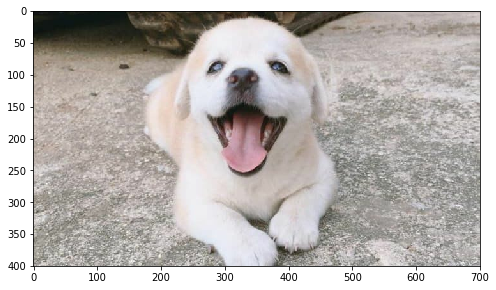

In [9]:
plt.imshow(image)
plt.show()

In [10]:
image = preprocess(image)
image_probs = pretrained_model.predict(image)

In [11]:
np.argmax(image_probs)

208

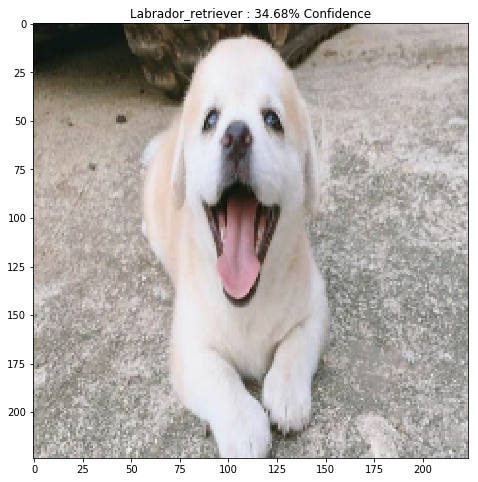

In [12]:
plt.figure()
plt.imshow(image[0])
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

## Fast Gradient Sign Method 구현

### perturbation 만들기

$$
adv_x = x - \epsilon \cdot sign \Big( \nabla_x J(\theta, x, y) \Big)
$$

이 때,

* $adv_x$ : adversarial image
* $x$ : original input image
* $y$ : original input label
* $\epsilon$ : perturbation 이 조금만 움직이게 해주는 값
* $\theta$ : model parameters
* $J$ : loss

$J(\theta, x, y)$ 로 loss 를 설정해서, 걍 이미지를 살짝 바꾸고 pretrained model 이 어떻게든 원래 label 을 지나쳐가도록 하려는 의도

Targeted adversarial attack 을 하려면 아래처럼 하면 된다.

$$
adv_x = x - \epsilon \cdot sign \Big( \nabla_x J(\theta, x, y_{target}) \Big)
$$

In [13]:
loss_object = tf.keras.losses.CategoricalCrossentropy()

def create_adversarial_pattern(input_image, input_label):
    '''
    args:
        원본 이미지, target_label
    return:
        grad 방향
    '''
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)

    # input_image 에 대한 gradient 구하기
    gradient = tape.gradient(loss, input_image)
    # gradient 에 대한 방향(sign) 구하기
    signed_grad = tf.sign(gradient)
    return signed_grad

### perturbation 시각화

target name: slug, index: 114



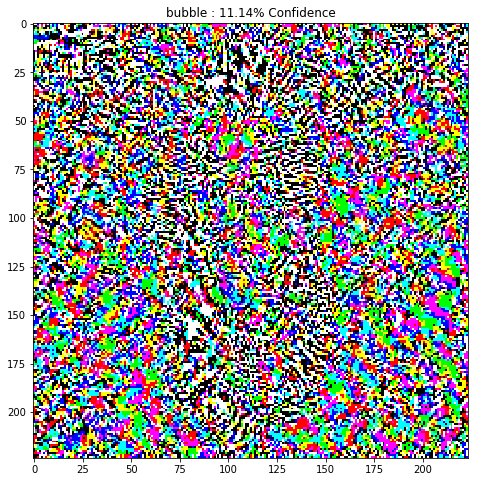

In [14]:
target_index = np.random.randint(1000)
print(f'target name: {class_dict.get(target_index)}, index: {target_index}',end='\n\n')
label = tf.one_hot(target_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

perturbations = create_adversarial_pattern(image, label)

pert_image_probs = pretrained_model.predict(perturbations)
plt.figure()
plt.imshow(perturbations[0])
_, pert_image_class, pert_class_confidence = get_imagenet_label(pert_image_probs)
plt.title('{} : {:.2f}% Confidence'.format(pert_image_class, pert_class_confidence*100))
plt.show()

## 결과

target class 로 잘 안간다.

epsilon 과 clip_by_values 의 parameters 에 따라 결과가 달라지므로 여러가지 해보자.

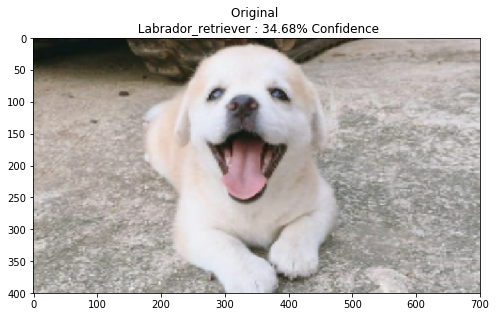

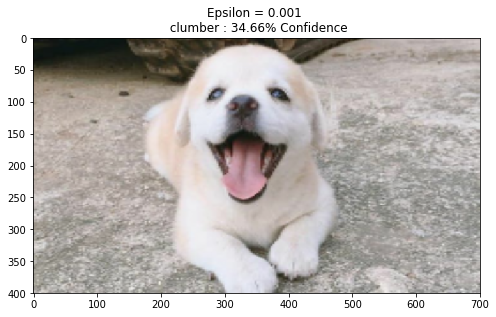

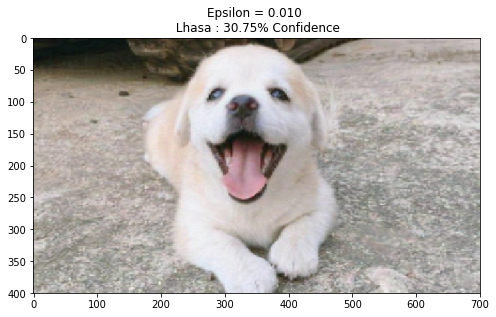

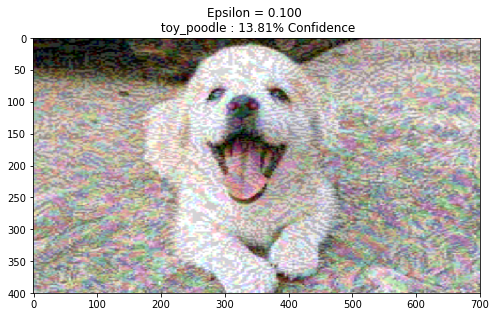

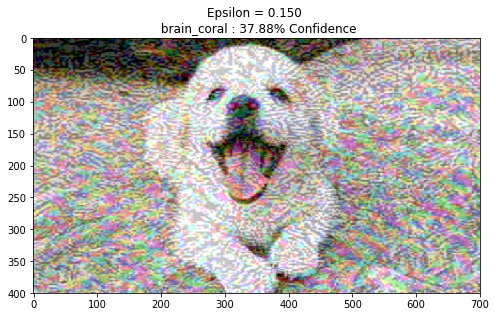

In [15]:
epsilons = [0, 1e-3, 1e-2, 1e-1, .15]
descriptions = [(f'Epsilon = {eps:.3f}') if eps else 'Original' for eps in epsilons]

for i, eps in enumerate(epsilons):
    adv_x = image - eps*perturbations
    adv_x = tf.clip_by_value(adv_x, 0, 1) # 사람이 보기에 이상하지 않도록 해주는 역할
    display_images(adv_x, descriptions[i], image_shape[:2])
    print()